In [11]:
from my_utils.stardisting import load_published_he_model
from my_utils import tile_processing as tp

from stardist.bioimageio_utils import normalize
from stardist.matching import matching_dataset as scorer
import os
from tqdm import tqdm
import pandas as pd

In [12]:
base_folder = r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets"

In [13]:
model_name = '2D_versatile_he'
model = load_published_he_model(
    folder_to_write_new_model_folder=os.path.join(base_folder, "Segmentation Models\StarDist"),
    name_for_new_model=model_name)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Using default values: prob_thresh=0.5, nms_thresh=0.4.

Ignore that, thresholds are: Thresholds(prob=0.6924782541382084, nms=0.3)


base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\Segmentation Models\StarDist\2D_versatile_he


In [14]:
def write_row(column_names, values, df):
    row = pd.DataFrame(pd.Series(index=column_names)).T
    for c, col_name in enumerate(column_names):
        row[col_name] = values[c]
    return pd.concat([df, row], ignore_index=True, axis=0)

In [15]:
path_ints = os.path.join(base_folder, "Interpolations")
interpolations = os.listdir(path_ints)

In [16]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
columns = ['Model', 'Interpolation', 'Dataset', 'Tile', 'Tau', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1-Score', 'Panoptic Quality']
df_scores = pd.DataFrame(columns=columns)

In [17]:
for interpolation in tqdm(interpolations, desc='Interpolation'):
# for interpolation in [interpolations[0]]:
    path_datasets = os.path.join(path_ints, interpolation)
    for dataset in os.listdir(path_datasets):
    # for dataset in [os.listdir(path_datasets)[0]]:
        path_imgs = os.path.join(os.path.join(path_datasets, dataset), r'images')
        path_msks = os.path.join(os.path.join(path_datasets, dataset), r'masks')
        tile_sets = tp.TileSetReader([path_imgs, path_msks], ['.tif', '.tif']).tile_sets
        # [0]-basenames, [1][0]-images, [1][1]-gt, need to add [1][2]-pred
        tile_sets[1].append([])
        for i, img in enumerate(tile_sets[1][0]):
            img = normalize(img, pmin=1, pmax=99.8, axis=(0, 1, 2))
            pred, _ = model.predict_instances(img)
            tile_sets[1][2].append(pred)
            gt = tile_sets[1][1][i]
            for tau in taus:
            # for tau in [taus[0]]:
                scores = scorer([gt], [pred], thresh=tau, show_progress=False)._asdict()
                values = [model_name, interpolation, dataset, tile_sets[0][i], tau,
                          scores['tp'], scores['fp'], scores['fn'],
                          scores['precision'], scores['recall'], scores['f1'], scores['panoptic_quality']]
                df_scores = write_row(columns, values, df_scores)
            

Interpolation: 100%|██████████| 26/26 [17:36<00:00, 40.62s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1023.5, 1023.5, -0.5)

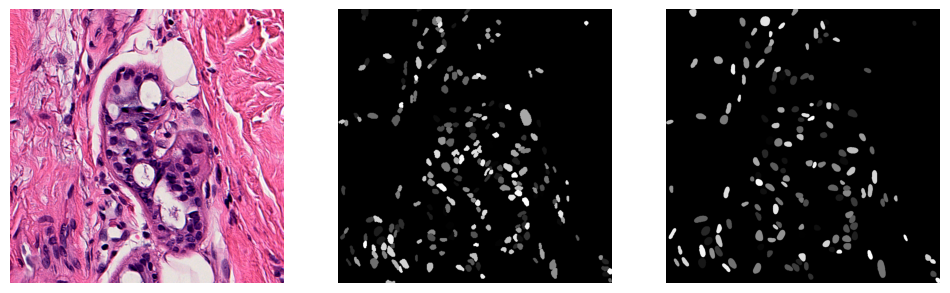

In [18]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjust figsize as needed
axs[0].imshow(img, cmap='gray')
axs[0].axis('off')
axs[1].imshow(gt, cmap='gray')
axs[1].axis('off')
axs[2].imshow(pred, cmap='gray')
axs[2].axis('off')

In [19]:
df_scores

,Model,Interpolation,Dataset,Tile,Tau,TP,FP,FN,Precision,Recall,F1-Score,Panoptic Quality
0,2D_versatile_he,L - 20x - 0_,CoNSeP,test_1,0.1,60,0,804,1.000000,0.069444,0.129870,0.082033
1,2D_versatile_he,L - 20x - 0_,CoNSeP,test_1,0.2,59,1,805,0.983333,0.068287,0.127706,0.081602
2,2D_versatile_he,L - 20x - 0_,CoNSeP,test_1,0.3,57,3,807,0.950000,0.065972,0.123377,0.080371
3,2D_versatile_he,L - 20x - 0_,CoNSeP,test_1,0.4,52,8,812,0.866667,0.060185,0.112554,0.076856
4,2D_versatile_he,L - 20x - 0_,CoNSeP,test_1,0.5,44,16,820,0.733333,0.050926,0.095238,0.068969
...,...,...,...,...,...,...,...,...,...,...,...,...
23629,2D_versatile_he,R - 40x - 3_,JHU,Skin_train_5,0.5,132,21,109,0.862745,0.547718,0.670051,0.507751
23630,2D_versatile_he,R - 40x - 3_,JHU,Skin_train_5,0.6,121,32,120,0.790850,0.502075,0.614213,0.477633
23631,2D_versatile_he,R - 40x - 3_,JHU,Skin_train_5,0.7,97,56,144,0.633987,0.402490,0.492386,0.397460
23632,2D_versatile_he,R - 40x - 3_,JHU,Skin_train_5,0.8,52,101,189,0.339869,0.215768,0.263959,0.224694


In [20]:
out_folder = r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\Segmentation Scores\2D_versatile_he"
df_scores.to_csv(os.path.join(out_folder, 'Interpolation_Scoring.csv'), index=False)